### CNNMLP Implementation
- Based on [Joo et al., 2023](https://www.nature.com/articles/s41598-023-49514-2#)

![](../figures/bag.jpg)

In [1]:
import os, shutil, sys, warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from timeit import default_timer as timer 

import torch, gc
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary

from tqdm.auto import tqdm
from pyprojroot import here

sys.path.insert(0, f"{here()}/src")

from cnn import CNNMLP, MRIDataset
from model_train_eval_src import mae, mse, train_and_select_best_model

from timer import print_train_time
from plots import scatter_predicted_chronological, scatter_adjbrainage_age, scatter_bag_age, age_distribution_plot

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)
pd.reset_option("mode.chained_assignment")

PyTorch version: 2.7.1+cu126
torchvision version: 0.22.1+cu126


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
#gc.collect()
#torch.cuda.empty_cache()

In [4]:
!nvidia-smi

Fri Jul 11 17:06:41 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P0              65W / 280W |    836MiB / 11264MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
proj_dir = here()

In [6]:
torch.manual_seed(42)
base_model = CNNMLP(input_shape=1, hidden_units=32, output_shape=1).to(device)
#base_model

In [7]:
summary(model=base_model, input_size=(3, 1, 121, 145, 121))

Layer (type:depth-idx)                   Output Shape              Param #
CNNMLP                                   [3, 1]                    --
├─Conv3d: 1-1                            [3, 32, 119, 143, 119]    896
├─BatchNorm3d: 1-2                       [3, 32, 119, 143, 119]    64
├─ReLU: 1-3                              [3, 32, 119, 143, 119]    --
├─MaxPool3d: 1-4                         [3, 32, 118, 142, 118]    --
├─Conv3d: 1-5                            [3, 32, 118, 142, 118]    27,680
├─BatchNorm3d: 1-6                       [3, 32, 118, 142, 118]    64
├─ReLU: 1-7                              [3, 32, 118, 142, 118]    --
├─MaxPool3d: 1-8                         [3, 32, 59, 71, 59]       --
├─Conv3d: 1-9                            [3, 32, 59, 71, 59]       27,680
├─BatchNorm3d: 1-10                      [3, 32, 59, 71, 59]       64
├─ReLU: 1-11                             [3, 32, 59, 71, 59]       --
├─MaxPool3d: 1-12                        [3, 32, 29, 35, 29]       --
├─Conv

#### Load Training Data

In [8]:
data_directory = "/shared/uher/Murage/BrainAgefMRI/data/mri/" #"/data/sriharsha/brain_age_mri/mri/"
pheno_directory = "/shared/uher/Murage/BrainAgefMRI/data/mri_phenotype_partitioned.csv" #"/data/sriharsha/brain_age_mri/mri_phenotype_partitioned.csv"

In [9]:
df = pd.read_csv(pheno_directory)
df['filename'] = df['filename'] + '.gz'
df['filename'] = df['filename'].str.strip()

In [10]:
# Save train and validation filenames into list
train = df[df['split'] == 'TRAINING']
validation = df[df['split'] == 'VALIDATE']
train_ids = train['filename'].to_list()
validation_ids = validation['filename'].to_list()

print(f" Train N: {len(train_ids)} | Validation N: {len(validation_ids)}") 

 Train N: 2312 | Validation N: 570


In [11]:
train_n, val_n = [], []
for file in os.listdir(data_directory):
    #print(file)
    if file in train_ids:
        train_n.append(file)
        if not os.path.exists(f"/shared/uher/Murage/BrainAgefMRI/data/train/{file}"):
            shutil.copy(f"/shared/uher/Murage/BrainAgefMRI/data/mri/{file}", f"/shared/uher/Murage/BrainAgefMRI/data/train/{file}")
        else:
            continue

    if file in validation_ids:
        val_n.append(file)
        if not os.path.exists(f"/shared/uher/Murage/BrainAgefMRI/data/validation/{file}"):
            shutil.copy(f"/shared/uher/Murage/BrainAgefMRI/data/mri/{file}", f"/shared/uher/Murage/BrainAgefMRI/data/validation/{file}")
        else:
            continue

print(f"Train N: {len(set(train_n))}")
print(f"Validation N: {len(set(val_n))}")

Train N: 2312
Validation N: 570


In [12]:
train = train[['filename', 'scan_age', 'project']]
validation = validation[['filename', 'scan_age', 'project']]

#### Make Train Dataloader

In [13]:
train_data_directory = "/shared/uher/Murage/BrainAgefMRI/data/train/"
validation_data_directory = "/shared/uher/Murage/BrainAgefMRI/data/validation/"

In [14]:
train_dataset = MRIDataset(df=train, id_col='filename', target_col='scan_age', root_dir=train_data_directory)
validation_dataset = MRIDataset(df=validation, id_col='filename', target_col='scan_age', root_dir=validation_data_directory)

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=2, shuffle=False, pin_memory=True)

In [16]:
train.head()

,filename,scan_age,project
0,HBN-CBIC-sub-NDARDH086ZKK.nii.gz,9.488364,HBN
1,HBN-CBIC-sub-NDARJY676CWZ.nii.gz,11.823636,HBN
2,HBN-CBIC-sub-NDARWR247CE1.nii.gz,16.496691,HBN
5,HBN-CBIC-sub-NDARDR439HY2.nii.gz,13.463723,HBN
6,HBN-CBIC-sub-NDARTJ433TB5.nii.gz,12.997718,HBN


#### Print first train & validation samples

In [17]:
for i in range(5):
    try:
        image, label = train_dataset[i]
        print(f"Index: {i}, Image shape: {image.shape if hasattr(image, 'shape') else type(image)}, Label: {label}")
    except KeyError:
        print(f"Index: {i}, Image shape: {image.shape if hasattr(image, 'shape') else type(image)}, Label: {label}")
        #print(f"Index {i}: not found")

Index: 0, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([9.4884])
Index: 1, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([11.8236])
Index: 2, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([16.4967])
Index: 3, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([13.4637])
Index: 4, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([12.9977])


In [18]:
for i in range(5):
    try:
        image, label = validation_dataset[i]
        print(f"Index: {i}, Image shape: {image.shape if hasattr(image, 'shape') else type(image)}, Label: {label}")
    except KeyError:
        print(f"Index: {i}, Image shape: {image.shape if hasattr(image, 'shape') else type(image)}, Label: {label}")
        #print(f"Index {i}: not found")

Index: 0, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([9.4774])
Index: 1, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([16.4447])
Index: 2, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([9.1598])
Index: 3, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([14.1674])
Index: 4, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([9.0935])


##### Compare shape of image at each stage

In [19]:
image, label = next(iter(train_dataloader))
print(f'{image.shape}, {label}')

torch.Size([3, 1, 121, 145, 121]), tensor([[17.6000],
        [ 9.0000],
        [14.0000]])


##### Optimizer

In [20]:
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)

##### Train CNNMLP Model

In [21]:
cnnmlpmodel, tracking_loss = train_and_select_best_model(model=base_model, train_dataloader=train_dataloader, 
                    validation_dataloader=validation_dataloader, optimizer=optimizer, loss=mae, device=device, num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
-------
Train Loss: 9.7061 | Validation MAE: 18.1474 | RMSE: 19.1794 
Epoch: 2
-------
Train Loss: 4.6555 | Validation MAE: 6.4577 | RMSE: 6.8628 
Epoch: 3
-------
Train Loss: 4.4203 | Validation MAE: 2.8140 | RMSE: 3.1413 
Epoch: 4
-------
Train Loss: 4.4961 | Validation MAE: 12.5967 | RMSE: 13.1062 
Epoch: 5
-------
Train Loss: 4.4014 | Validation MAE: 2.8464 | RMSE: 3.1359 
Epoch: 6
-------
Train Loss: 4.2962 | Validation MAE: 3.8584 | RMSE: 4.1237 
Epoch: 7
-------
Train Loss: 4.1992 | Validation MAE: 3.0815 | RMSE: 3.3577 
Epoch: 8
-------
Train Loss: 4.2059 | Validation MAE: 3.4106 | RMSE: 3.7349 
Epoch: 9
-------
Train Loss: 4.2345 | Validation MAE: 6.3752 | RMSE: 6.7455 
Epoch: 10
-------
Train Loss: 4.2367 | Validation MAE: 3.1056 | RMSE: 3.3673 
Epoch: 11
-------
Train Loss: 4.3645 | Validation MAE: 4.0971 | RMSE: 4.4300 
Epoch: 12
-------
Train Loss: 4.2761 | Validation MAE: 3.4248 | RMSE: 3.7638 
Epoch: 13
-------
Train Loss: 4.2580 | Validation MAE: 5.1060 | RMSE:

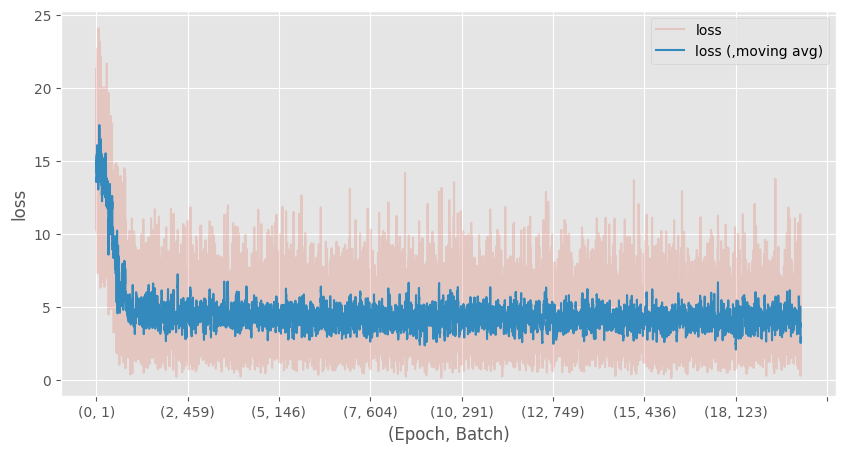

In [24]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10,5))
tracking_loss.plot(alpha=0.2, label='loss')
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (,moving avg)")

plt.xlabel("(Epoch, Batch)")
plt.ylabel("loss")
plt.legend(loc=0)
plt.show()